# Preprocessing and Tokenization

Rodrigo Becerra Carrillo

https://github.com/bcrodrigo

# Introduction

Notebook to perform Preprocessing and Tokenization on a reviews dataset of Amazon foods.

The dataset was sourced from [here](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews/data).

## Data Dictionary


| Column Name            | Description                                                               | Data Type |
| ---------------------- | ------------------------------------------------------------------------- | --------- |
| Id                     | Row ID                                                                    | int64     |
| ProductId              | Unique identifier for Product                                             | object    |
| UserId                 | Unique identifier for User                                                | object    |
| ProfileName            | Profile name of the user                                                  | object    |
| HelpfulnessNumerator   | Number of users who found the review helpful                              | int64     |
| HelpfulnessDenominator | Number of users who indicated wether they found the review helpful or not | int64     |
| Score                  | Rating between 1 and 5                                                    | int64     |
| Time                   | Timestamp for the review                                                  | int64     |
| Summary                | Brief summary of the review                                               | object    |
| Text                   | Full review                                                               | object    |


Previously, we performed EDA and noticed there were no missing values, and that there was a class imbalance in the `Score`. From the table above, we'll only use `Text` and `Score` as features and target variable, respectively.

## Import Custom Modules

In [1]:
import sys
sys.path

['/Users/rodrigo/anaconda3/envs/nlp_env/lib/python311.zip',
 '/Users/rodrigo/anaconda3/envs/nlp_env/lib/python3.11',
 '/Users/rodrigo/anaconda3/envs/nlp_env/lib/python3.11/lib-dynload',
 '',
 '/Users/rodrigo/anaconda3/envs/nlp_env/lib/python3.11/site-packages']

In [2]:
sys.path.append('..')

In [3]:
from src.preprocessing import preprocess_dataset

In [4]:
preprocess_dataset?

Signature: preprocess_dataset(csv_filename, rebalance=True)
Docstring:
Function to preprocess a reviews datascet in csv into a dataframe with score and text. It performs the following steps:
    1. Drop duplicate rows
    2. Map score from 1-5 to 0-2
    3. Rebalance the dataframe based on the scores

Parameters
----------
csv_filename : str
    Path to the csv file containing the data. Note the file is expected to be compressed using gzip.

rebalance : bool, optional
    Optional flag indicates to balance the number of reviews.

Returns
-------
tuple
    Pandas DataFrames (df_orig, df_rebalanced), each with two columns: text and review score.

    if rebalance is False
        df_orig : contains all records
        df_rebalanced : is an empty dataframe

    if rebalance is True
        df_orig : contains all records minus those used to rebalance the review score
        df_rebalanced : contains all records used to balanced number of reviews by score

    Note that in either case pd.co

# Import Libraries and Load DataFrame

In [5]:
import numpy as np
import pandas as pd

In [6]:
file_path = '../data/Reviews.csv.gz'

Call `preprocess_dataset` to rebalance dataframe according to the review scores

In [7]:
dforig, dfnew = preprocess_dataset(file_path,rebalance=True)

In [8]:
dforig.shape

(304317, 2)

In [9]:
dfnew.shape

(89262, 2)

In [10]:
dfnew.shape[0] + dforig.shape[0]

393579

In [11]:
dfnew['Score'].value_counts()

Score
0    29754
1    29754
2    29754
Name: count, dtype: int64

In [12]:
dforig['Score'].value_counts()

Score
2    277004
0     27313
Name: count, dtype: int64

# Text Cleaning

In this section we'll add some text cleaning routines, to make the tokenization process faster. We'll remove html tags, extra whitespace, and punctuation.

In [13]:
from src.preprocessing import dataset_text_cleanup

In [14]:
dataset_text_cleanup?

Signature: dataset_text_cleanup(df)
Docstring:
To perform text cleanup for a dataframe with two columns 'Text'  and 'Score'. This step is to be performed prior to tokenization.

The cleanup steps are as follows:
1. Remove HTML tags
2. Remove URLs
3. Remove excessive white space

Parameters
----------
df : DataFrame
    Pandas dataframe with 'Text' and 'Score' columns

Returns
-------
DataFrame
    Pandas dataframe with cleaned text as defined above
File:      ~/Documents/Github/nlp_reviews/src/preprocessing.py
Type:      function

In [15]:
dfnew_clean = dataset_text_cleanup(dfnew)

/Users/rodrigo/Documents/Github/nlp_reviews/jupyter_notebooks/../src/preprocessing.py:96: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


# Tokenization

In this section we'll tokenize the contents of `dfnew_clean`. The intent will be to use the Bag-of-Words model with Scikit-Learn.

We need to:

1. Use spaCy to define a custom tokenizer that removes punctuation, stop words, and performs lemmatization
2. Instantiate a `CountVectorizer` and pass custom tokenizer
3. Figure out what is the minimum document frequency for the tokens

## Testing the custom tokenizer on first 5 reviews

In [18]:
dfnew_clean.shape

(89262, 2)

In [19]:
# get the first 5 reviews of the dataset
dftest = dfnew_clean['Text'].head()
first5_rev = dftest.values.tolist()

In [16]:
import spacy
nlp = spacy.load("en_core_web_sm")

def custom_tokenizer(sentence):    
    doc = nlp(sentence)

    token_list = [token.lemma_ 
                  for token in doc 
                  if not token.is_punct 
                  and not token.is_stop 
                  and not token.is_space 
                  and not token.is_digit 
                  and not token.is_currency
                 ]

    return token_list

In [20]:
# tokenizer
custom_tokenizer(first5_rev[0])

['husband',
 'originally',
 'Germany',
 'enjoy',
 'good',
 'hearty',
 'bread',
 'hard',
 'crust',
 'order',
 'mix',
 'Amazon.com',
 'mind',
 'unfortunately',
 'disappoint',
 'bread',
 'rise',
 'expect',
 'thick',
 'crust',
 'crusty',
 'like',
 'bread',
 'Germany',
 'actually',
 'tough"',
 'bread',
 'maker',
 'prepare',
 'follow',
 'direction',
 'T.',
 'yeast',
 'inferior',
 'check',
 'date',
 'mix',
 'expire',
 'purchase',
 'fact',
 'second',
 'package',
 'sit',
 'shelf']

In [21]:
# show the full review
print(first5_rev[0])

My husband is originally from Germany and enjoys good hearty breads with hard crusts. I order this mix from Amazon.com with him in mind. Unfortunately we were disappointed because the bread did not rise as expected. It did get a thick crust, but was not crusty like the breads in Germany. It was actually "tough".I used the bread maker to prepare it and followed the directions to a T. Perhaps the yeast was inferior. Checked the date on the mix and it was not expired.So I will not be purchasing it again. In fact, I have the second two packages sitting on the shelf.


In [22]:
custom_tokenizer(first5_rev[3])

['give',
 'product',
 'star',
 'know',
 'product',
 'old',
 'case',
 'bad',
 'tea',
 'open',
 'box',
 'home',
 'office',
 'return',
 'product',
 'tea',
 'taste',
 'bad',
 'smell',
 'bad',
 'try',
 'throw',
 'tea']

In [23]:
print(first5_rev[3])

If I could have given this product no stars I would have. I don't know if the product was old or just a case of bad tea. I opened both boxes (one for home and one for the office) or I would have returned the product. The tea not only tasted bad but it smelled bad as well. I even had others try it and they had to throw the tea out as well.


So far this is working as intended.

## Test the Count Vectorizer

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

In [25]:
bagofwords = CountVectorizer(tokenizer=custom_tokenizer)
bagofwords.fit(first5_rev)

first5_rev_transformed = bagofwords.transform(first5_rev)
first5_rev_transformed.shape

/Users/rodrigo/anaconda3/envs/nlp_env/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(5, 128)

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

def top_words(Xtransf,bagofwords,num_words=20):
    assert isinstance(num_words,int),"num_words must be an integer"
    
    word_counts = pd.DataFrame(
        {"counts": Xtransf.toarray().sum(axis=0)},
        index = bagofwords.get_feature_names_out()).sort_values("counts", ascending=False)

    word_counts.head(num_words).plot(kind="bar", figsize=(15, 5), legend=False)
    plt.title(f"Top {num_words} most frequently occurring words")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

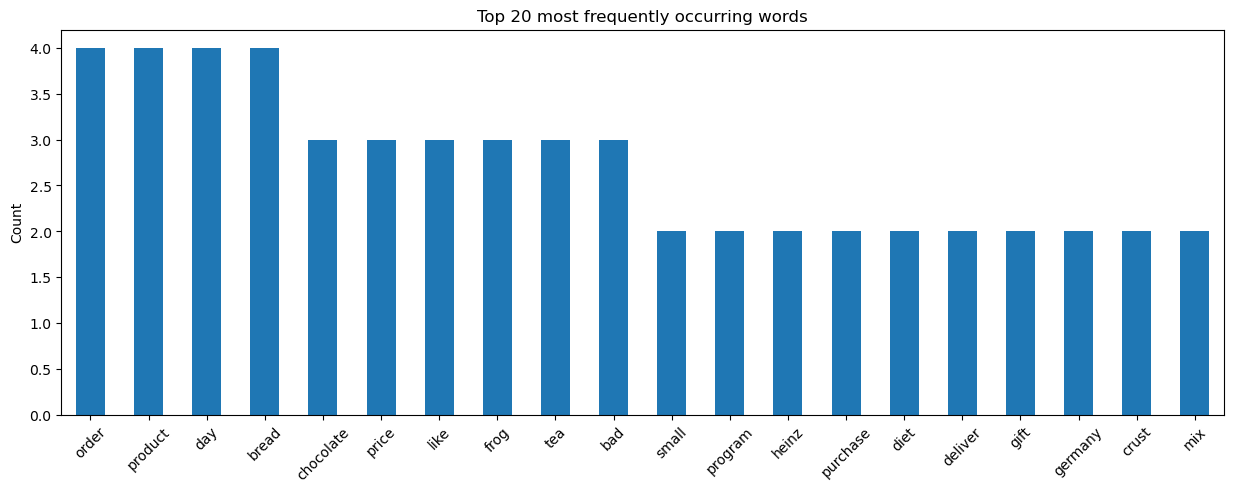

In [27]:
top_words(first5_rev_transformed,bagofwords,20)

# Establishing minimum document frequency and downsampling further

Now we'll add a large portion of the reviews into the tokenization pipeline. Recall the clean dataset is over 89k records

In [28]:
dfnew_clean.shape

(89262, 2)

Therefore what we will do is as follows:

1. Downsample to 10% of the records.
2. Split between train (80%) and test sets (20%).
3. Instantiate a Count Vectorizer, set `max_features = 500` and `min_df = 10`.
4. Transform the training set and see the top/bottom words.

In [55]:
def downsample_dataframe(df, fraction):
    """Function to extract a fraction of a cleaned dataframe while keeping the same proportion of scores.

    Parameters
    ----------
    df : DataFrame
        Pandas dataframe with 'Text' and 'Score' columns
    fraction : float
        Number representing the fraction of records to be extracted

    Returns
    -------
    DataFrame
        Pandas dataframe with less rows as defined above
    """
    assert (fraction > 0.0) & (
        fraction <= 1.0
    ), "The fraction should be a positive number between 0.0 and 1.0"

    # Empty df to us as an accumulator
    df_acc = pd.DataFrame()

    avail_score = dfnew["Score"].value_counts().index

    for score in avail_score:
        tempdf = (
            dfnew.query(f"Score == {score}")
            .sample(frac=fraction, random_state=10)
            .copy()
        )

        df_acc = pd.concat([df_acc, tempdf], axis=0)

    return df_acc

In [56]:
df_downsampled = downsample_dataframe(dfnew_clean,0.1)

In [58]:
df_downsampled.shape

(8925, 2)

In [30]:
from sklearn.model_selection import train_test_split

In [61]:
X = df_downsampled['Text']
y = df_downsampled['Score'].values

X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                 train_size = 0.8,
                                                 random_state = 10,
                                                 stratify = y)

In [62]:
X_train.shape

(7140,)

In [63]:
# limit the document frequency to 10
# cap the max number of features to 500
bagofwords_v1 = CountVectorizer(tokenizer=custom_tokenizer,
                                min_df = 10,
                                max_features = 500)

In [66]:
bagofwords_v1.fit(X_train)

CountVectorizer(max_features=500, min_df=10,
                tokenizer=<function custom_tokenizer at 0x15a8549a0>)

In [68]:
X_train_transformed = bagofwords_v1.transform(X_train)
X_train_transformed.shape

(7140, 500)

In [69]:
import pandas as pd
import matplotlib.pyplot as plt


def top_words(Xtransf, bagofwords, num_words=20):
    """Function to plot the top and bottom words used in a vocabulary

    Parameters
    ----------
    Xtransf : CSR matrix
        Sparse matrix with the transformed text
    bagofwords : object
        Instance of bag-of-words count vectorizer
    num_words : int, optional
        Number of words to plot, default is 20
    """
    assert isinstance(num_words, int), "num_words must be an integer"


    word_counts = pd.DataFrame({"counts": Xtransf.toarray().sum(axis=0)},
        index=bagofwords.get_feature_names_out()
        ).sort_values("counts", ascending=False)


    # plot top words first
    plt.figure(1)
    word_counts.head(num_words).plot(kind="bar",
        figsize=(15, 5), 
        legend=False)

    plt.title(f"Top {num_words} most frequently occurring words")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()


    # plot bottom words
    plt.figure(2)

    word_counts.tail(num_words).plot(kind="bar", figsize=(15, 5), legend=False)
    
    plt.title(f"Bottom {num_words} least frequently occurring words")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()


<Figure size 640x480 with 0 Axes>

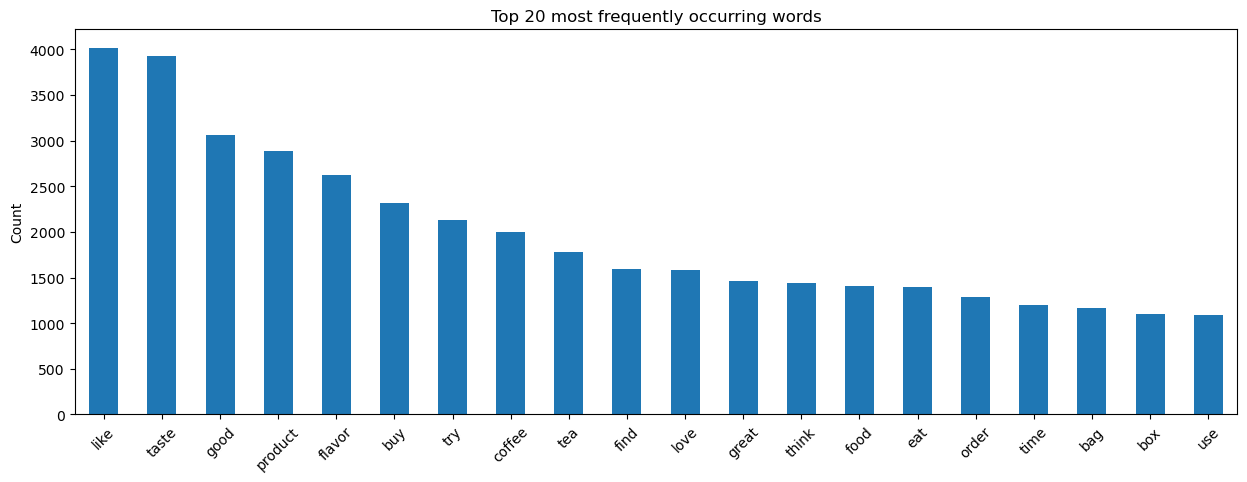

<Figure size 640x480 with 0 Axes>

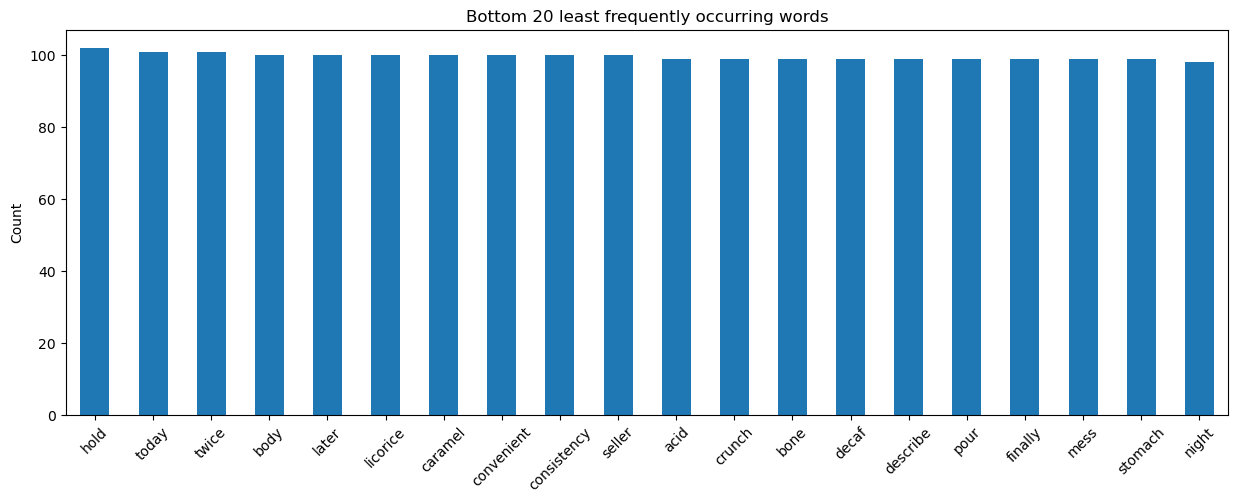

In [70]:
top_words(X_train_transformed, bagofwords_v1)

# Conclusion and further actions

Limiting the number of features and further downsampling the training set allows us to instantiate a count vectorizer that we could use to peform predictions on sentiment analysis. 

With higher computing power we might be able to use a larger fraction of the corpus, but for now we'll proceed to try and model sentiment using 10% of the records.